In [21]:
import torch
import copy
import numpy as np
import itertools
import random as rd
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [22]:
# !pip install torch

# Purpose

Purpose of this branch is to test convergence properties of the network using one-hot-vectors for the state space instead of 0-3, as the OHV format may be easier for the network to operate on. Due to the need to operate on zero vectors we will

- add a small noise function gamma to each OHV
- use He initialisation for weight initialisation

In [23]:
class Environment():
    
    #fields:
    #a grid of size defined by parameter
    #b, a tuple repsenting the delivery location
    #a, a tuple representing the package location
    #size, an int representing the horizontal and vertical dimensions of the grid
    def __init__(self, size:int):
        self.size = size
        self.actions = ['north', 'south', 'west', 'east']
        self.reward_pickup = 50
        self.reward_deliver = 50
        self.reward_move = -1
        self.reset_env()
    
    def reset_env(self):
        combinations = list(itertools.product(list(range(self.size)), repeat=2))
        rd.shuffle(combinations)
        self.a, self.b, self.agent_coords = combinations[0:3]
        self.collected = 0
        self.done = False
        self.terminated = False
        self.test_length = 0 #an additional parameter to determine how long the environment has been active for
        self.setup_grid()

    def coordinates_to_noisy_ohv(self, coordinate:int):
        ohv = np.zeros(4)
        noise = np.random.normal(-1e-5, 1e-5, ohv.shape)
        ohv[coordinate] = 1
        ohv = ohv + noise
        return ohv

    #method to set up the original grid including a location
    def setup_grid(self):
        self.grid = np.zeros((self.size, self.size))
            
        # Place the "a" and "b" locations on the grid
        if self.a is None:
            x, y = rd.randint(0, self.size - 1), rd.randint(0, self.size - 1)
            while (x, y) == self.b:
                x, y = rd.randint(0, self.size - 1), rd.randint(0, self.size - 1)
            self.a = (x, y)  # A represented by 1
        else:
            x, y = self.a
        self.grid[x, y] = 1  # Place "a" on the grid

        if self.b is None:
            x, y = rd.randint(0, self.size - 1), rd.randint(0, self.size - 1)
            while (x, y) == self.a:
                x, y = rd.randint(0, self.size - 1), rd.randint(0, self.size - 1)
            self.b = (x, y)  # B represented by 2
        else:
            x, y = self.b
        self.grid[x, y] = 2  # Place "b" on the grid

        # Place the "home" location (0) on the grid
        x, y = self.agent_coords
        self.grid[x, y] = 0

    def get_state(self):
        #This method unpacks the coordinates into a tuple which can be used to index the qmatrix or for easy incorporation to the Deep Q Network
        coords = [self.agent_coords[0], self.agent_coords[1], self.a[0], self.a[1], self.b[0], self.b[1]]
        coords = [self.coordinates_to_noisy_ohv(c) for c in coords]
        coords.append(np.array(self.collected))
        return np.hstack(coords)
        return np.ndarray.flatten(np.array(coords))

        return np.array([self.agent_coords[0], self.agent_coords[1], self.collected, self.a[0], self.a[1], self.b[0], self.b[1]])
    
    #Method which updates the location of the agent on the grid. Currently just zeroes whatever it landed on - can include other logic instead
    def move_agent(self, action):
        #For agent move, note that 0 = up, 1=down, 2=left, 3=right
        self.test_length += 1

        #Assign new coordinates for agent to exist at
        new_x, new_y = self.agent_coords
        if action == 'north' and self.agent_coords[1] > 0:
            new_y -= 1
        elif action == 'south' and self.agent_coords[1] < self.size - 1:
            new_y += 1
        elif action == 'west' and self.agent_coords[0] > 0:
            new_x -= 1
        elif action == 'east' and self.agent_coords[0] < self.size - 1:
             new_x += 1
        
        #Update the grid based on new agent coordinates
        self.grid[self.agent_coords] = 0
        self.agent_coords = (new_x, new_y)
        self.grid[self.agent_coords] = -1

        #Handle logic based on new agent location
        if self.collected == 0:
            if self.agent_coords == self.a:
                self.collected = 1
                reward = self.reward_pickup
            else:
                reward = self.reward_move
        
        else:
            if self.agent_coords == self.b:
                self.done = True
                reward = self.reward_deliver
            else:
                reward = self.reward_move

                #This code was considered test code which could be useful in exiting early
        if self.test_length > 70:
            self.terminated = True
        return reward, self.done, self.terminated

    def get_grid(self):
        return self.grid.tolist()

    def plot_grid(self, snapshot, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_facecolor('white')
        else:
            ax.clear()
        
        # Plot the grid
        ax.imshow(np.array([[0]]), cmap="bone", extent=[0, self.size, 0, self.size])

        for i in range(self.size):
            for j in range(self.size):
                cell_value = snapshot[i][j]
                if cell_value == -1:
                    # Display agent image in the cell
                    imagebox = OffsetImage(agent_img, zoom=0.08)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                elif cell_value == 1:
                    # Display package image in the cell
                    imagebox = OffsetImage(package_img, zoom=0.03)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                elif cell_value == 2:
                    # Display destination image in the cell
                    imagebox = OffsetImage(destinationB_img, zoom=0.05)
                    ab = AnnotationBbox(imagebox, (j + 0.5, self.size - i - 0.5), frameon=False)
                    ax.add_artist(ab)
                else:
                    ax.text(j + 0.5, self.size - i - 0.5, self.grid[i, j], ha='center', va='center', fontsize=20, color='black')
        
        # Set axis properties
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_xticks(np.arange(self.size) + 1)
        ax.set_yticks(np.arange(self.size) + 1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, linewidth=2, color='white')
        
        # Set title
        ax.set_title("Package Delivery Agent")
        
        # Show the plot
        #plt.show()
        return ax
agent_img = plt.imread('agent.jpg')
package_img = plt.imread('package.jpg')
destinationB_img = plt.imread('destinationB.jpg')

In [24]:
# Define the TransportAgent agent
#new statespace size should be 25 - this represents six 4-size one-hot-vectors, plus a collected flag
class TransportAgent:
    def __init__(self, statespace_size=25, gamma=0.99, learning_rate=0.01, start_epsilon=1.0,
                 epsilon_decay_factor=0.999, min_epsilon=0.1, replay_buffer_size=1000,
                 batch_size=200, network_copy_frequency=500): #Modified slightly with a lower epsilon
        self.statespace_size = statespace_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.model2 = self.prepare_torch()
        self.memory = []  # Using a list instead of a deque
        self.epsilon = start_epsilon
        self.epsilon_min = min_epsilon
        self.epsilon_decay_factor = epsilon_decay_factor
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.network_copy_frequency = network_copy_frequency
        self.steps_since_copy = 0  # Counter for network copy

    def prepare_torch(self):
        l1 = self.statespace_size
        l2 = 150
        l3 = 100
        l4 = 4
        self.model = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l3),
            torch.nn.ReLU(),
            torch.nn.Linear(l3, l4)
        )

        model2 = copy.deepcopy(self.model)
        model2.load_state_dict(self.model.state_dict())
        self.loss_fn = torch.nn.HuberLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return model2

    def update_target(self):
        if self.steps_since_copy >= self.network_copy_frequency:
            self.model2.load_state_dict(self.model.state_dict())
            self.steps_since_copy = 0
            print("Target model updated")

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.replay_buffer_size:
            self.memory.pop(0)  # Remove the oldest experience

    def get_qvals(self, state):
        state1 = torch.from_numpy(state).float()
        qvals_torch = self.model(state1)
        qvals = qvals_torch.data.numpy()
        return qvals

    def get_maxQ(self, s):
        return torch.max(self.model2(torch.from_numpy(s).float())).float()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(range(4))  # Random action
        q_values = self.get_qvals(state)
        return np.argmax(q_values[0])  # Greedy action

    def process_minibatch(self, minibatch):
        states = []
        actions = []
        targets = []
        for state, action, reward, next_state, done in minibatch:
            q_values = self.get_qvals(state)
            if done:
                q_values[action] = reward
            else:
                q_values[action] = reward + self.gamma * self.get_maxQ(next_state)
            states.append(state)
            actions.append(action)
            targets.append(q_values[0])
        return np.array(states), np.array(actions), np.array(targets) #this is returning a thruple of state transitions?

    def train_one_step(self, states, actions, targets):
        state1_batch = torch.from_numpy(states).float()
        # state1_batch = torch.Tensor([torch.from_numpy(s).float() for s in states])
        action_batch = torch.Tensor(actions)
        Q1 = self.model(state1_batch)
        X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
        Y = torch.tensor(targets)
        loss = torch.nn.HuberLoss()(X, Y)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters(): #Test implementing gradient clipping if necessary
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        return loss.item()

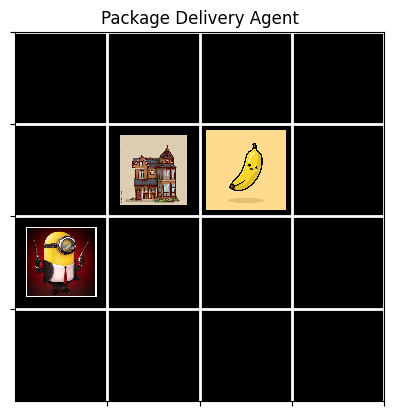

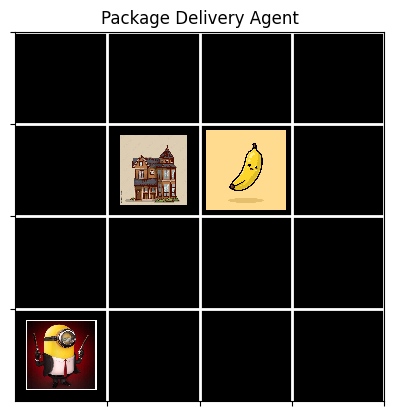

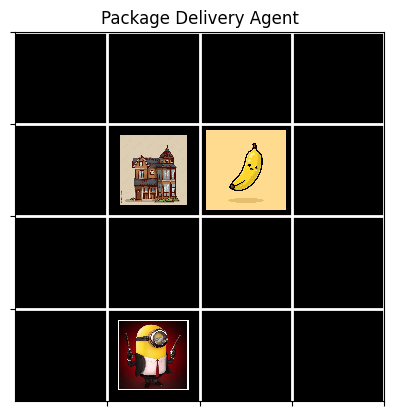

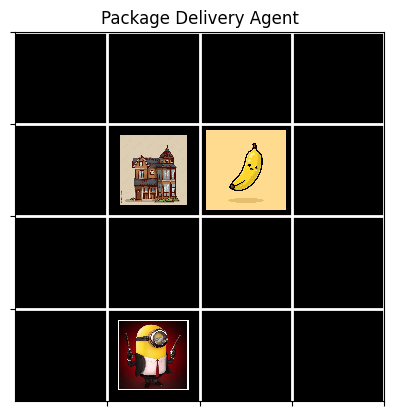

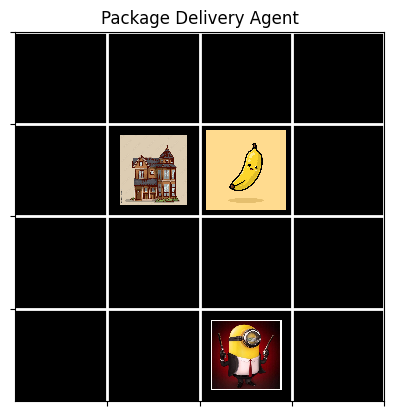

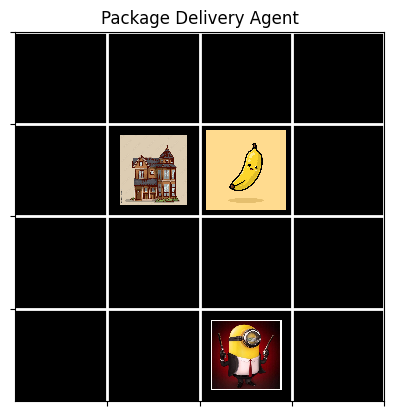

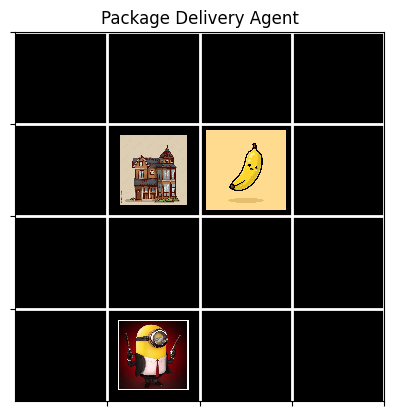

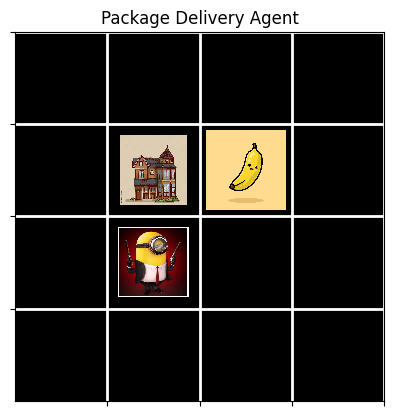

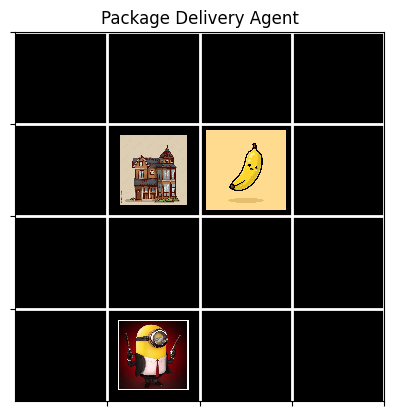

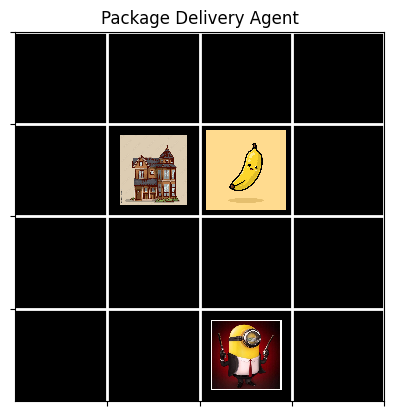

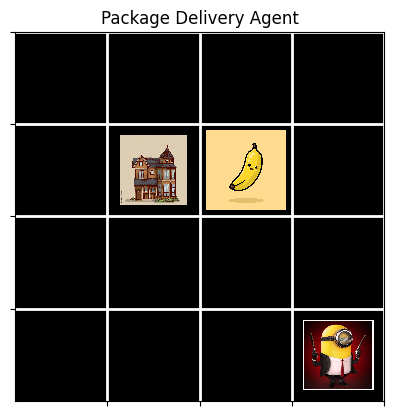

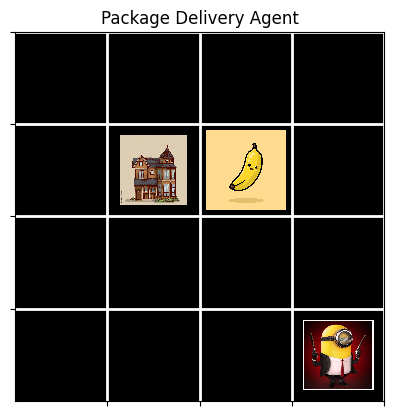

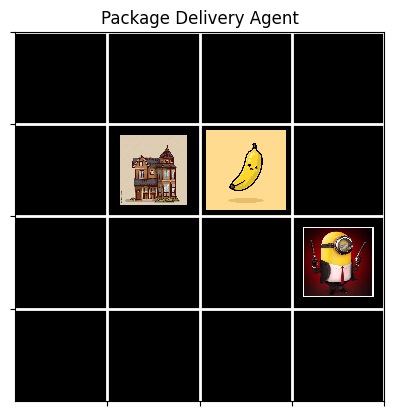

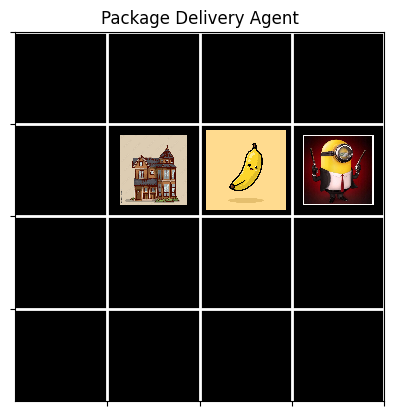

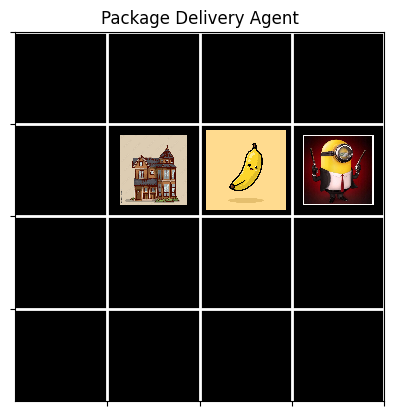

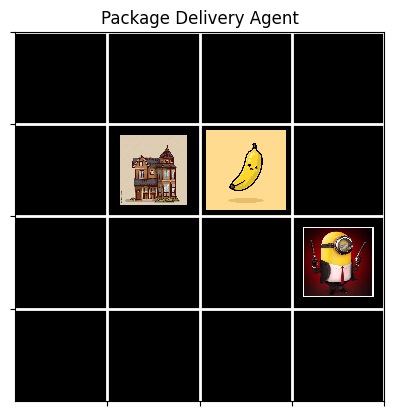

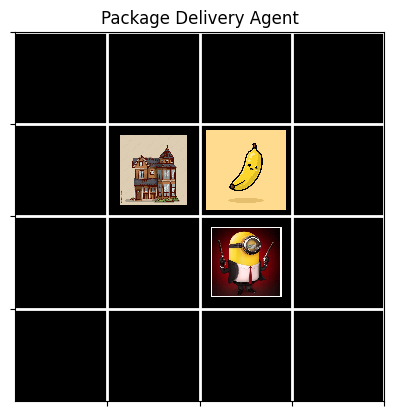

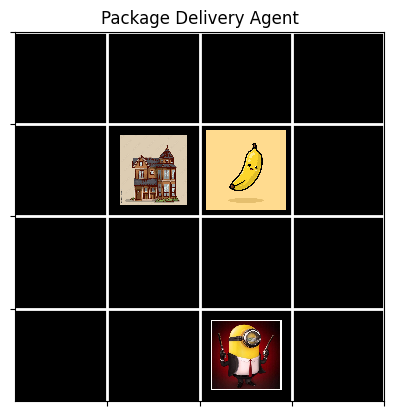

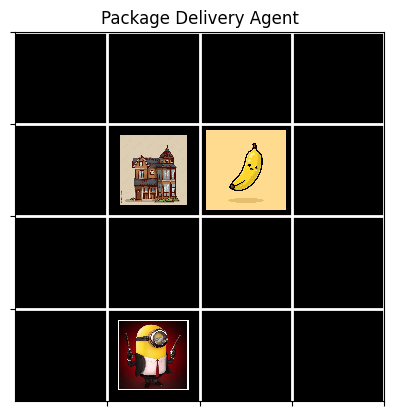

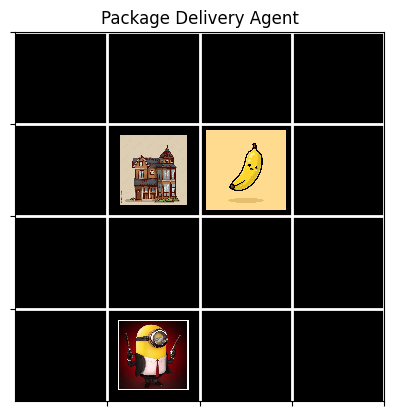

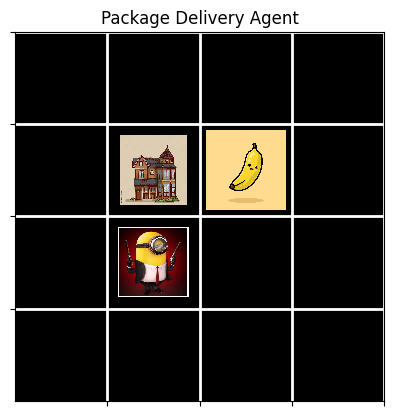

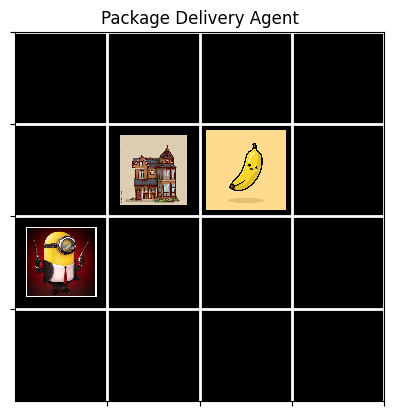

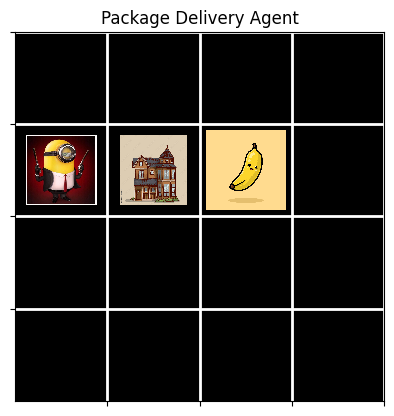

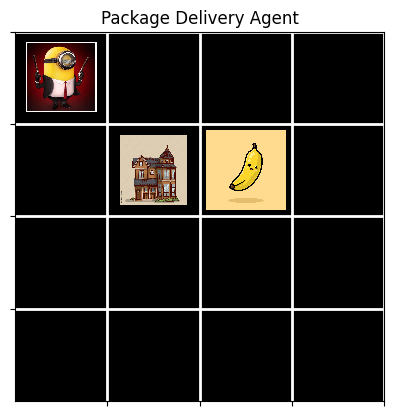

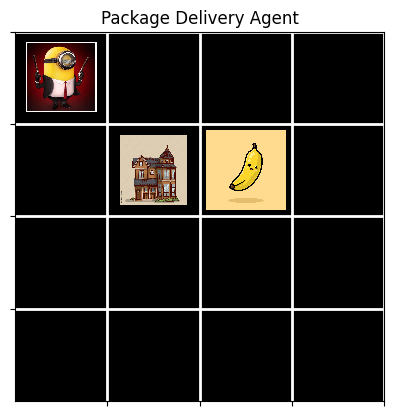

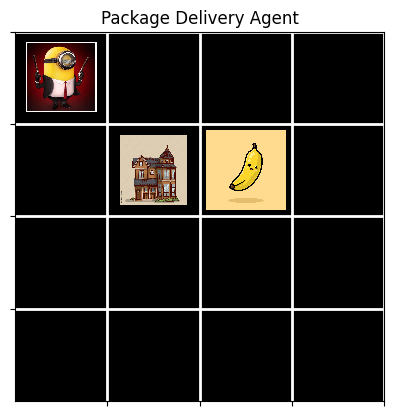

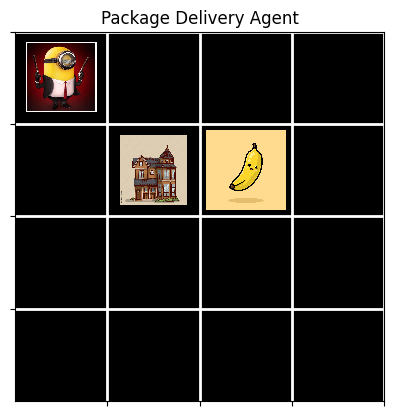

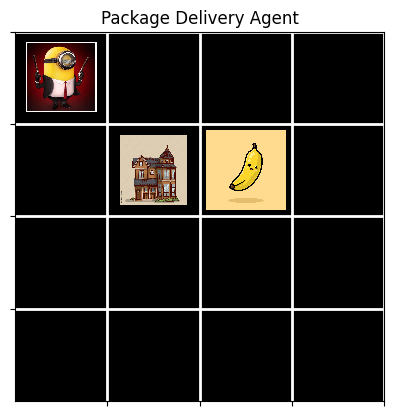

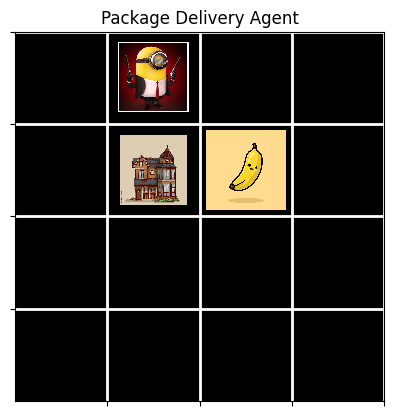

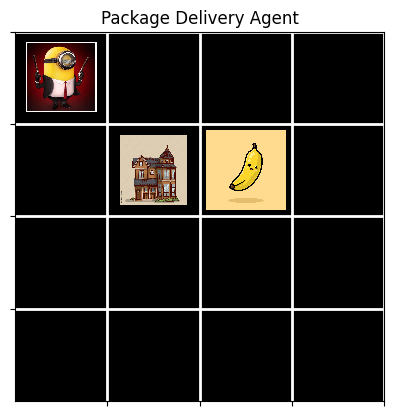

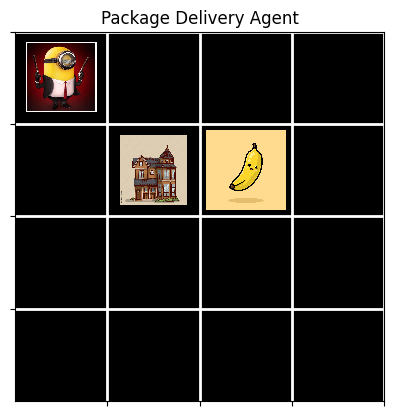

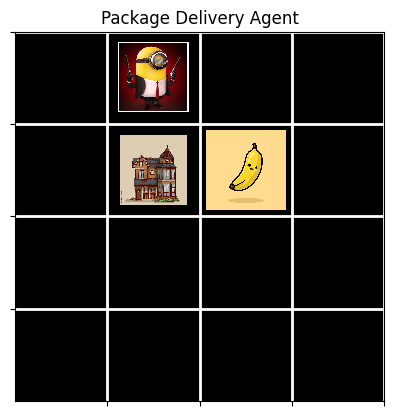

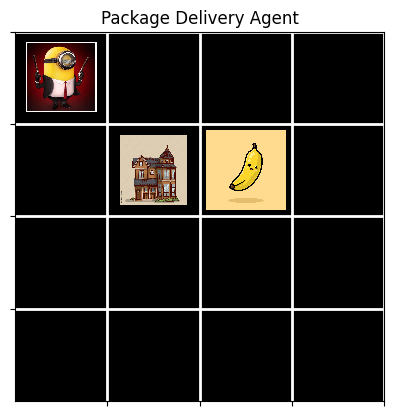

KeyboardInterrupt: 

In [25]:
if __name__ == "__main__":
    # env = TransportEnv()  # Create the environment
    env = Environment(4)
    agent = TransportAgent(learning_rate=0.1, start_epsilon=1.0, epsilon_decay_factor=0.999,
                           min_epsilon=0.1, replay_buffer_size=5000, batch_size=100, network_copy_frequency=20)

    episodes = 5
    snapshots=[]
    for episode in range(episodes):
        env.reset_env()
        state = env.get_state()  # Reset the environment and get the initial state
        done = False
        terminated = False
        total_reward = 0
        episode_losses = []
        while (not done and not terminated):
            # print("state", state)
            action = agent.act(state)
            reward, done, terminated = env.move_agent(env.actions[action])
            next_state = env.get_state()
            # next_state, reward, done = env.step(env.actions[action])
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            # print("agent.memory[-1]",agent.memory[-1])
            snapshots.append(env.get_grid())
            state = next_state
            fig, ax = plt.subplots()
            ax.set_facecolor('white')
            
            m = ax.imshow(env.grid, cmap="bone", extent=[0, env.size, 0, env.size])
            env.plot_grid(env.get_grid(), ax)
            fig.canvas.draw()
            plt.pause(0.2)
            
            # Training
            if len(agent.memory) > agent.batch_size:
                minibatch_indices = np.random.choice(len(agent.memory), agent.batch_size, replace=False)
                minibatch = [agent.memory[i] for i in minibatch_indices]
                states_batch, actions_batch, targets_batch = agent.process_minibatch(minibatch)
                loss = agent.train_one_step(states_batch, actions_batch, targets_batch)
                episode_losses.append(loss)
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay_factor, agent.epsilon_min)
        if len(episode_losses) > 0:
            mean_loss = sum(episode_losses)/len(episode_losses)
        else:
            mean_loss = "n/a"
        agent.steps_since_copy += 1
        agent.update_target()
        # print("state", state)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon} | Loss: {mean_loss}")
        print(f"Terminated: {terminated} | Done: {done}")

        